# TASK 1
# Step 1. Import libraries, extract pickle files and explore the data

In [148]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Flatten, Dense, ReLU,
                                     SimpleRNN, LSTM, 
                                     BatchNormalization, 
                                     Conv1D, Conv2D, 
                                     AveragePooling1D, MaxPooling2D)
#pip install keras-tuner --upgrade
import kerastuner
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [141]:
with open("time_series_1.pickle", "rb") as fin:
    ts1 = pickle.load(fin)
with open("time_series_2.pickle", "rb") as fin:
    ts2 = pickle.load(fin)
with open("y.pickle", "rb") as fin:
    y = pickle.load(fin)

In [514]:
#make the type suitable for keras
ts1 = ts1.astype(np.float32)
ts2 = ts2.astype(np.float32)

In [3]:
#check the lables
np.unique(y)

array([0., 1., 2., 3.])

## Are there any patterns?

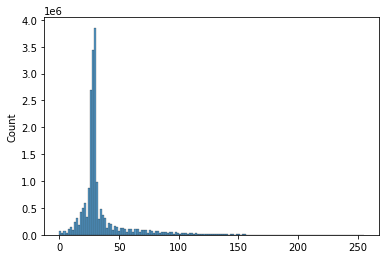

In [5]:
#what are the most common values for sensor 1?
sns.histplot(ts1.flatten(), bins=150)
plt.show()

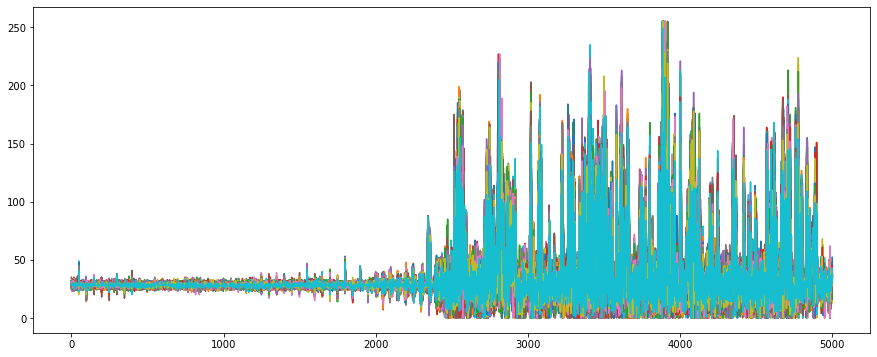

In [149]:
#How are observations distributed in time?
#Let's have a look at 100 random sequences
figure(figsize=(15, 6))

for i in random.choices(range(0,4000), k=100):
    ax=plt.plot(range(0,5000),ts1[i])

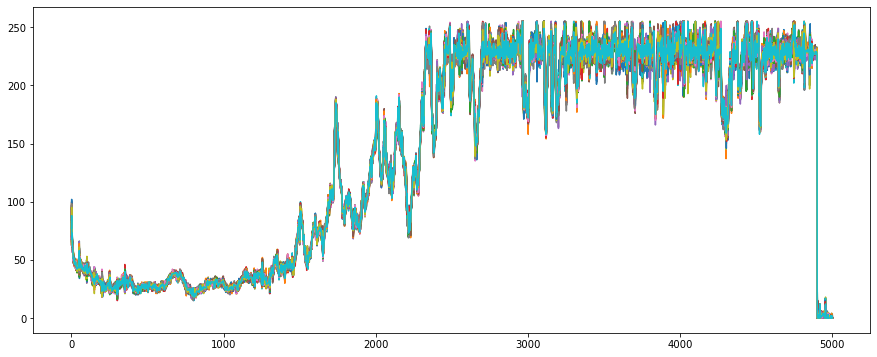

In [151]:
#TS2
figure(figsize=(15, 6))
for i in random.choices(range(0,4000), k=100):
    ax=plt.plot(range(0,5000),ts2[i])

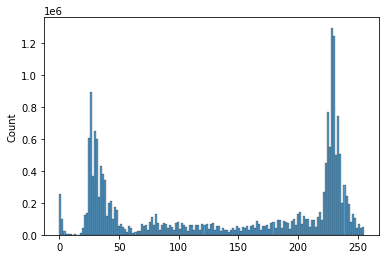

In [6]:
#what are the most common values for sensor 2?
sns.histplot(ts2.flatten(), bins=150)
plt.show()

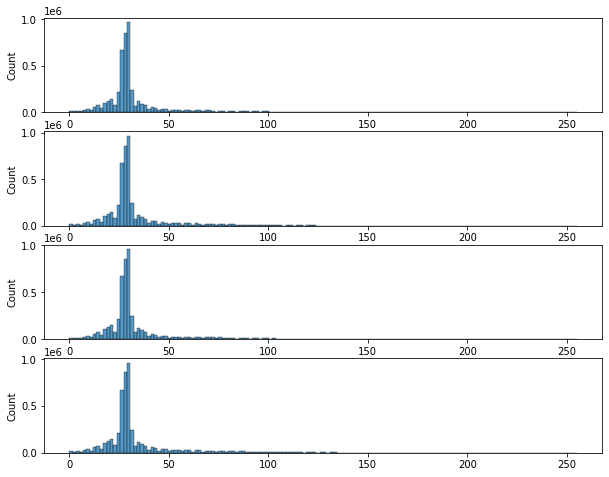

In [23]:
#And what about values for different labels?
fg, axs = plt.subplots(4, 1, figsize=(10, 8))
for label in [0, 1, 2, 3]:
    sns.histplot(ts1[y == label].flatten(), bins=150, ax=axs[label])

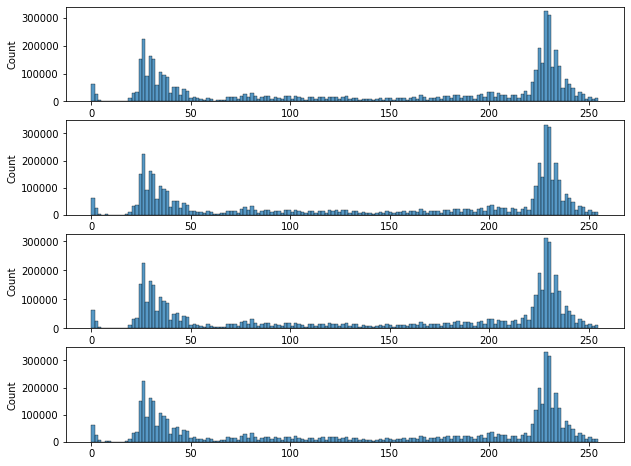

In [24]:
fg, axs = plt.subplots(4, 1, figsize=(10, 8))
for label in [0, 1, 2, 3]:
    sns.histplot(ts2[y == label].flatten(), bins=150, ax=axs[label])

* Visually, distributions for different operating modes do not change dramatically. It is hard to derive any pattern. Probably RNN will help.

# Step 2. Data preparation and preprocessing
* Creating a convenient function to prepare train, test, val.

In [7]:
from numpy.random import default_rng
rng = default_rng(12345)

SIZE = 1000 # size of each class 
TRAIN_IND, TEST_IND = int(0.7 * SIZE), int(0.85 * SIZE)
classes = np.unique(y)

def build_train_test_val(ts: np.ndarray, 
                         target: np.ndarray, 
                         classes: np.ndarray=classes,
                         unsqueeze=True):
    #store the values in a dictionary
    keys = ["train", "test", "val"]
    x = {key : np.array([]) for key in keys}
    y = {key : np.array([]) for key in keys}
    for label in classes:
        subset = ts[target == label]
        # rng.shuffle(subset)
        x_subset = {"train" : subset[:TRAIN_IND],
                    "test" : subset[TRAIN_IND:TEST_IND],
                    "val" : subset[TEST_IND:]}
        
        for key in keys:
            x[key] = np.vstack([x[key], x_subset[key]]) \
                      if x[key].size else x_subset[key]

        for key in keys:
            labels = label * np.ones(x_subset[key].shape[0])
            y[key] = np.concatenate((y[key], labels)) \
                        if y[key].size else labels
    for key in keys:
        y[key] = tf.keras.utils.to_categorical(y[key], len(classes))
    if unsqueeze:
        return {key : (x[key][:, :, None], y[key]) for key in keys}
    else:
        return {key : (x[key], y[key]) for key in keys}

# Step 3. Developing a RNN to predict the operating mode of the turbine 

## RNN with 2 layers applied to a full 5000 sequence

In [602]:
data_single = build_train_test_val(ts1, y)

In [ ]:
model_simple = Sequential([
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(20),
    Dense(4,activation='softmax')
])
model_simple.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(1e-3),
                     metrics=['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, 
                                                     restore_best_weights=True,
                                                     monitor="val_accuracy")
log = model_simple.fit(data_single["train"][0],
                       data_single["train"][1], 
                       epochs=100,
                        validation_data=data_single["test"],
                       callbacks = [early_stopping_cb])

* I did not run this model on my device, but asked a class-mate with a more powerful machine

* The model learns slow: it took 2 hours to run 29 epochs. Accuracy on the test is 72%. And it is only 1 sensor. Probably, we need to work with reduced length of sequence.

## Try the same architecture for a shorter model (cut first 3500 observations)

In [145]:
ts1_cut=np.delete(ts1,range(0,4000), axis=1)
data_cut = build_train_test_val(ts1_cut, y)
model_simple = Sequential([
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(20),
    Dense(4,activation='softmax')
])
model_simple.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(1e-3),
                     metrics=['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, 
                                                     restore_best_weights=True,
                                                     monitor="val_accuracy")
log = model_simple.fit(data_cut["train"][0],
                       data_cut["train"][1], 
                       epochs=20,
                        validation_data=data_cut["test"],
                       callbacks = [early_stopping_cb])

Epoch 1/20
88/88 [==============================] - 47s 513ms/step - loss: 1.4354 - accuracy: 0.2718 - val_loss: 1.3693 - val_accuracy: 0.3217
Epoch 2/20
88/88 [==============================] - 45s 510ms/step - loss: 1.3457 - accuracy: 0.3611 - val_loss: 1.3208 - val_accuracy: 0.4150
Epoch 3/20
88/88 [==============================] - 44s 495ms/step - loss: 1.2657 - accuracy: 0.4261 - val_loss: 1.2438 - val_accuracy: 0.4500
Epoch 4/20
88/88 [==============================] - 44s 502ms/step - loss: 1.1913 - accuracy: 0.4732 - val_loss: 1.1800 - val_accuracy: 0.4783
Epoch 5/20
88/88 [==============================] - 46s 520ms/step - loss: 1.1334 - accuracy: 0.5021 - val_loss: 1.1222 - val_accuracy: 0.4767
Epoch 6/20
88/88 [==============================] - 46s 526ms/step - loss: 1.0862 - accuracy: 0.5164 - val_loss: 1.0693 - val_accuracy: 0.5350
Epoch 7/20
88/88 [==============================] - 44s 504ms/step - loss: 1.0398 - accuracy: 0.5475 - val_loss: 1.0477 - val_accuracy: 0.5350

In [146]:
#record accuracy
model_simple.evaluate(data["val"][0], data["val"][1])

19/19 [==============================] - 3s 134ms/step - loss: 0.8647 - accuracy: 0.6450


[0.8646827340126038, 0.6449999809265137]

* The model is running and learning. Resulting accuracy - 0.6450 after 20 epochs. We limited the sequence to last 1500 observations, since the variance for them is the highest (we spot it visually on the above exploration plots). However, completely getting rid out of the information is probably not the best way for reducing the lenght of the sequence. At the same time, we dont know yet how the RNN will work with both ts1 and ts2. Hence, let's work with minute average later on. 

## RNN for minute average for 1 sensor (ts1)

* Since a sequence of 5000 is too massive for the RNN, let's create a function calculating minute average for the time series

In [8]:
def get_minute_average(ts1):
    size = ts1.shape[1]
    # [4000, 83] – will be the new size of the network
    return ts1[:, -60 * (size // 60):, None].reshape(4000, 60, -1).mean(axis=1)

In [93]:
data_single_average = build_train_test_val(get_minute_average(ts1), y)
model_simple = Sequential([
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(20),
    Dense(4,activation='softmax')
])
model_simple.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(1e-3),
                     metrics=['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, 
                                                     restore_best_weights=True,
                                                     monitor="val_accuracy")
log = model_simple.fit(data_single_average["train"][0].astype(np.float32),
                       data_single_average["train"][1], 
                       epochs=100,
                        validation_data=data_single_average["test"],
                       callbacks = [early_stopping_cb])

Epoch 1/100
88/88 [==============================] - 6s 46ms/step - loss: 1.4570 - accuracy: 0.2625 - val_loss: 1.3808 - val_accuracy: 0.2600
Epoch 2/100
88/88 [==============================] - 4s 41ms/step - loss: 1.3456 - accuracy: 0.3311 - val_loss: 1.2857 - val_accuracy: 0.3883
Epoch 3/100
88/88 [==============================] - 4s 43ms/step - loss: 1.2184 - accuracy: 0.4643 - val_loss: 1.0465 - val_accuracy: 0.5783
Epoch 4/100
88/88 [==============================] - 4s 45ms/step - loss: 0.9562 - accuracy: 0.6136 - val_loss: 0.8719 - val_accuracy: 0.6500
Epoch 5/100
88/88 [==============================] - 4s 44ms/step - loss: 0.8475 - accuracy: 0.6571 - val_loss: 0.7846 - val_accuracy: 0.6900
Epoch 6/100
88/88 [==============================] - 4s 42ms/step - loss: 0.7931 - accuracy: 0.6893 - val_loss: 0.7474 - val_accuracy: 0.7133
Epoch 7/100
88/88 [==============================] - 4s 44ms/step - loss: 0.7575 - accuracy: 0.7079 - val_loss: 0.8154 - val_accuracy: 0.6483
Epoch 

In [94]:
#record accuracy
model_simple.evaluate(data_single_average["val"][0], data_single_average["val"][1])

19/19 [==============================] - 0s 13ms/step - loss: 0.4489 - accuracy: 0.8483


[0.4488716721534729, 0.8483333587646484]

* The learning stopped after 41 epochs and resulting accuracy is 0.8483. Great accuracy for one sensor predicting all 4 labels! Probably the pitch angle affects generator torque or vice versa.

## Try LSTM on one sensor (ts1) with minutes average

In [95]:
model_single_LSTM = Sequential([
    BatchNormalization(),
    LSTM(units=16),
    Dense(4, activation='softmax')
])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, 
                                                restore_best_weights=True, 
                                                monitor="val_accuracy")
model_single_LSTM.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'],
            )

model_single_LSTM.fit(
    data_single_average["train"][0], 
    data_single_average["train"][1], 
    validation_data=data_single_average["test"],
    shuffle=True,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
88/88 [==============================] - 7s 50ms/step - loss: 1.3886 - accuracy: 0.2793 - val_loss: 1.5372 - val_accuracy: 0.2500
Epoch 2/100
88/88 [==============================] - 4s 42ms/step - loss: 1.3223 - accuracy: 0.3521 - val_loss: 1.7930 - val_accuracy: 0.2500
Epoch 3/100
88/88 [==============================] - 4s 43ms/step - loss: 1.2083 - accuracy: 0.4446 - val_loss: 2.0547 - val_accuracy: 0.2500
Epoch 4/100
88/88 [==============================] - 4s 42ms/step - loss: 1.1425 - accuracy: 0.4821 - val_loss: 1.9068 - val_accuracy: 0.2517
Epoch 5/100
88/88 [==============================] - 4s 42ms/step - loss: 1.1049 - accuracy: 0.5025 - val_loss: 1.4887 - val_accuracy: 0.3350
Epoch 6/100
88/88 [==============================] - 4s 42ms/step - loss: 1.0695 - accuracy: 0.5039 - val_loss: 1.1291 - val_accuracy: 0.4733
Epoch 7/100
88/88 [==============================] - 4s 42ms/step - loss: 1.0316 - accuracy: 0.5511 - val_loss: 1.0678 - val_accuracy: 0.5300
Epoch 

In [96]:
#check LSTM ts1 performance 
model_single_LSTM.evaluate(data_single_average["val"][0], data_single_average["val"][1])

19/19 [==============================] - 0s 11ms/step - loss: 0.4466 - accuracy: 0.8433


[0.4465614855289459, 0.8433333039283752]

In [97]:
#double-check the predicted label
np.argmax(model_single_LSTM.predict(data_single_average["val"][0][10][None, :, :])) == np.argmax(data_single_average["val"][1][10])

True

* Adding LSTM layer did not improve the accuracy. Let's combine the two sensors.

## Using both features ( angle+generator)

In [603]:
mean1, mean2 = get_minute_average(ts1), get_minute_average(ts2)

In [604]:
data_both_average = build_train_test_val(np.concatenate((mean1[:, :, None], 
                                            mean2[:, :, None]), axis=2), 
                     y, unsqueeze=False)

In [605]:
#double check the dimension
data_both_average["train"][0].shape

(2800, 83, 2)

### LSTM on minutes for both sensors

In [606]:
model_both_average_LSTM = Sequential([
    BatchNormalization(),
    LSTM(units=32),
    Dense(4, activation='softmax')
])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                restore_best_weights=True, 
                                                monitor="val_accuracy")
model_both_average_LSTM.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(4e-4),
              metrics=['accuracy'],
            )

model_both_average_LSTM.fit(
    data_both_average["train"][0], 
    data_both_average["train"][1], 
    validation_data=data_both_average["test"],
    shuffle=True,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
88/88 [==============================] - 7s 53ms/step - loss: 1.3568 - accuracy: 0.3518 - val_loss: 1.5578 - val_accuracy: 0.2500
Epoch 2/100
88/88 [==============================] - 4s 47ms/step - loss: 1.2494 - accuracy: 0.4296 - val_loss: 1.5538 - val_accuracy: 0.2500
Epoch 3/100
88/88 [==============================] - 4s 49ms/step - loss: 1.1819 - accuracy: 0.4886 - val_loss: 1.6242 - val_accuracy: 0.2500
Epoch 4/100
88/88 [==============================] - 4s 45ms/step - loss: 1.1364 - accuracy: 0.5114 - val_loss: 1.9914 - val_accuracy: 0.2500
Epoch 5/100
88/88 [==============================] - 4s 47ms/step - loss: 1.0638 - accuracy: 0.5550 - val_loss: 2.0369 - val_accuracy: 0.2500
Epoch 6/100
88/88 [==============================] - 4s 45ms/step - loss: 0.9853 - accuracy: 0.5886 - val_loss: 1.5285 - val_accuracy: 0.3550
Epoch 7/100
88/88 [==============================] - 4s 47ms/step - loss: 0.9475 - accuracy: 0.6139 - val_loss: 1.2397 - val_accuracy: 0.5133
Epoch 

In [627]:
#check 
model_both_average_LSTM.evaluate(data_both_average["val"][0], data_both_average["val"][1])

19/19 [==============================] - 1s 13ms/step - loss: 0.3069 - accuracy: 0.8800


[0.3068731427192688, 0.8799999952316284]

Adding another feature (generator torque) has increased the accuracy by around 2-3%.

### Conv1D on minutes for both sensors

In [629]:
model_both_average_Conv1D = Sequential([
    BatchNormalization(),
    Conv1D(1, kernel_size=5, strides=1, input_shape=data_both_average["train"][0].shape[1:]), 
    AveragePooling1D(2),
    Flatten(),
    Dense(4, activation='softmax')
])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                restore_best_weights=True, 
                                                monitor="val_accuracy")
model_both_average_Conv1D.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(3e-4),
              metrics=['accuracy'],
            )

model_both_average_Conv1D.fit(
    data_both_average["train"][0], 
    data_both_average["train"][1], 
    validation_data=data_both_average["test"],
    shuffle=True,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
88/88 [==============================] - 1s 8ms/step - loss: 1.5421 - accuracy: 0.1829 - val_loss: 25.1100 - val_accuracy: 0.2500
Epoch 2/100
88/88 [==============================] - 1s 6ms/step - loss: 1.4283 - accuracy: 0.2396 - val_loss: 8.3349 - val_accuracy: 0.2500
Epoch 3/100
88/88 [==============================] - 1s 6ms/step - loss: 1.3792 - accuracy: 0.3332 - val_loss: 3.1842 - val_accuracy: 0.2500
Epoch 4/100
88/88 [==============================] - 1s 6ms/step - loss: 1.3409 - accuracy: 0.3764 - val_loss: 1.7047 - val_accuracy: 0.2800
Epoch 5/100
88/88 [==============================] - 1s 7ms/step - loss: 1.3052 - accuracy: 0.4043 - val_loss: 1.3625 - val_accuracy: 0.3317
Epoch 6/100
88/88 [==============================] - 1s 6ms/step - loss: 1.2709 - accuracy: 0.4271 - val_loss: 1.2835 - val_accuracy: 0.4033
Epoch 7/100
88/88 [==============================] - 1s 6ms/step - loss: 1.2364 - accuracy: 0.4489 - val_loss: 1.2426 - val_accuracy: 0.4333
Epoch 8/100


In [630]:
model_both_average_Conv1D.evaluate(data_both_average["val"][0], data_both_average["val"][1])

19/19 [==============================] - 0s 4ms/step - loss: 0.4063 - accuracy: 0.8450


[0.4063146710395813, 0.8450000286102295]

* Adding convolution 1D layer has not improved the resulting accuracy comparing to previous model, however, it ran much quicker and did not lose too much of performance. Let's try it now on full 5000 sequence.

### Conv1D on full sequence with 1 more layer, increased kernel_size and 1 LSTM layer

In [610]:
data_both_full = build_train_test_val(np.concatenate((ts1[:, :, None], 
                                            ts2[:, :, None]), axis=2), 
                     y, unsqueeze=False)

In [611]:
#double-check the dimension
data_both_full["train"][0].shape

(2800, 5000, 2)

In [612]:
model_Conv1D_LSTM = Sequential([
    BatchNormalization(),
    Conv1D(1, kernel_size=30, strides=5, input_shape=data_both_full["train"][0].shape[1:]), 
    AveragePooling1D(10),
    Conv1D(1, kernel_size=20, strides=5, input_shape=data_both_full["train"][0].shape[1:]), 
    LSTM(32, return_sequences=True),
    Flatten(),
    Dense(4, activation='softmax')
])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                restore_best_weights=True, 
                                                monitor="val_accuracy")
model_Conv1D_LSTM.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(3e-4),
              metrics=['accuracy'],
            )

model_Conv1D_LSTM.fit(
    data_both_full["train"][0], 
    data_both_full["train"][1], 
    validation_data=data_both_full["test"],
    shuffle=True,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
88/88 [==============================] - 6s 39ms/step - loss: 1.3813 - accuracy: 0.2454 - val_loss: 1.3686 - val_accuracy: 0.2433
Epoch 2/100
88/88 [==============================] - 3s 33ms/step - loss: 1.3396 - accuracy: 0.3846 - val_loss: 1.2745 - val_accuracy: 0.3867
Epoch 3/100
88/88 [==============================] - 3s 32ms/step - loss: 1.1982 - accuracy: 0.4754 - val_loss: 1.1593 - val_accuracy: 0.4883
Epoch 4/100
88/88 [==============================] - 3s 34ms/step - loss: 1.1165 - accuracy: 0.5079 - val_loss: 1.1295 - val_accuracy: 0.4883
Epoch 5/100
88/88 [==============================] - 3s 32ms/step - loss: 1.0800 - accuracy: 0.5268 - val_loss: 1.0999 - val_accuracy: 0.4933
Epoch 6/100
88/88 [==============================] - 3s 30ms/step - loss: 1.0475 - accuracy: 0.5536 - val_loss: 1.0725 - val_accuracy: 0.5267
Epoch 7/100
88/88 [==============================] - 3s 35ms/step - loss: 1.0154 - accuracy: 0.5654 - val_loss: 1.0461 - val_accuracy: 0.5333
Epoch 

In [631]:
model_Conv1D_LSTM.evaluate(data_both_full["val"][0], data_both_full["val"][1])

19/19 [==============================] - 1s 11ms/step - loss: 0.3642 - accuracy: 0.8733


[0.3642311990261078, 0.8733333349227905]

* By far working with full 5000 sequence is not helping to improve the accuracy.

# Task 2
* The answer to this question is most likely found in the nature of both approaches. RNN was designed to derive insights and discover patterns in sequences. Its key strength is the ability to memorize previous inputs. Such layers as LSTM or GRU can help in overcoming the learning / forgetting dilemma. Applying RNN to NLP problems, speech recognition, and music creation appears to be very reasonable. The order of the words in a sentence is critical for understanding its meaning and determining its structure. The use of time-series prediction, on the other hand, is less obvious because we don't know the context of observations. In our case, the length of the sequence (5000) also adds to the confusion of RNN application.

* CNNs, on the other hand, have exceptional spatial reasoning abilities. We can aggregate information much faster by converting a 5000-pixel sequence with two features into a 100-by-100-pixel image (sliding in 2 dimensions defining the kernel size and number of strides). We probably don't need all 10,000 data points per observation to classify the turbine's operating mode, following the logic of image recognition, where we don't need high resolution images to make simple classifications. Instead, we can convolute the initial 'image,' extracting patterns – filters from which we can make predictions. 

# Tasks 3, 4
Building the convolutional neural network with 2D convolutional layers

In [614]:
#treating the sequence as 4000 different 100*100 images
joined_ts = np.concatenate((ts1, ts2), axis=1).reshape(ts1.shape[0], 
                                                       int(np.sqrt(2 * ts1.shape[1])),
                                                       -1,
                                                       1)

In [615]:
#check the dimension
joined_ts.shape

(4000, 100, 100, 1)

In [616]:
image_data = build_train_test_val(joined_ts, unsqueeze=False, target=y)

In [617]:
#put the train model into function to stop copying the code when applying different models
def train(model, lr=3e-4, patience=10, epochs=50):
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience, 
                                                restore_best_weights=True, 
                                                monitor="val_accuracy")
    model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr),
                metrics=['accuracy'],
                )

    model.fit(
        image_data["train"][0],
        image_data["train"][1], 
        validation_data=image_data["test"],
        shuffle=True,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    return model

In [618]:
image_data["train"][0].shape[1:]

(100, 100, 1)

In [620]:
#replicating the CNN3-32 model from Figure 12 of the article 
#strides are not defined, after experimenting, the 'best' combination of strides are 3,3,3
model_Conv2D = Sequential([
                    Conv2D(filters=32, kernel_size=3, strides=3,
                                        input_shape=image_data["train"][0].shape[1:]),
                    Conv2D(filters=32, kernel_size=3, strides=3),
                    tf.keras.layers.Dropout(.2),
                    Conv2D(filters=16, kernel_size=3, strides=3,activation="relu"),
                    MaxPooling2D(pool_size=(3, 3)),
                    Flatten(),
                    #Fully connected NN relates to Dense layer in Keras
                    #Dense(64, activation="relu"),
                    Dense(4, activation="softmax")
    ])

In [621]:
#check dimensions
for layer in model_Conv2D.layers:
    print(layer.output_shape)

(None, 33, 33, 32)
(None, 11, 11, 32)
(None, 11, 11, 32)
(None, 3, 3, 16)
(None, 1, 1, 16)
(None, 16)
(None, 4)


In [624]:
model_Conv2D = train(model_Conv2D)

Epoch 1/50
88/88 [==============================] - 3s 26ms/step - loss: 0.7806 - accuracy: 0.7689 - val_loss: 0.3167 - val_accuracy: 0.8817
Epoch 2/50
88/88 [==============================] - 2s 26ms/step - loss: 0.5914 - accuracy: 0.8207 - val_loss: 0.3520 - val_accuracy: 0.8850
Epoch 3/50
88/88 [==============================] - 2s 28ms/step - loss: 0.5079 - accuracy: 0.8443 - val_loss: 0.3669 - val_accuracy: 0.8500
Epoch 4/50
88/88 [==============================] - 2s 26ms/step - loss: 0.4495 - accuracy: 0.8564 - val_loss: 0.4673 - val_accuracy: 0.8933
Epoch 5/50
88/88 [==============================] - 2s 27ms/step - loss: 0.4755 - accuracy: 0.8468 - val_loss: 0.3156 - val_accuracy: 0.8783
Epoch 6/50
88/88 [==============================] - 2s 25ms/step - loss: 0.4158 - accuracy: 0.8596 - val_loss: 0.3136 - val_accuracy: 0.8750
Epoch 7/50
88/88 [==============================] - 2s 23ms/step - loss: 0.4170 - accuracy: 0.8571 - val_loss: 0.4143 - val_accuracy: 0.9033
Epoch 8/50
88

In [632]:
#evaluate the model
model_Conv2D.evaluate(image_data["val"][0], image_data["val"][1])

19/19 [==============================] - 0s 8ms/step - loss: 0.3272 - accuracy: 0.8917


[0.3272165060043335, 0.8916666507720947]

* This 'magic' model has overperformed all the previously discussed models (Simple RNN, LSTM, Conv1D). It learns very quick (80% after 3 epochs).

# Task 5. Trying to improve the CNN
* After many hours of trying different architectures, strides, kernel sizes, learning rates and number of layers, I decided to implement a tuning library kerastuner, allowing to find the best architecture half automatically. Half, because the user needs to limit the set of paramaters manually. The more computational power we have – the greater spread and variety of tuning parameters the model would consider, resulting in better model choice.

In [493]:
#Let's try architecture suggested in the TDS article 
#https://towardsdatascience.com/hyperparameter-tuning-with-kerastuner-and-tensorflow-c4a4d690b31a
def build_model(hp):
    # create model object
    model = keras.Sequential([
    #adding first convolutional layer    
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=12, max_value=30, step=6),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=(100,100,1)),
    # adding second convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=12, max_value=24, step=6),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=12, max_value=30, step=6),
        activation='relu'
    ),
    # output layer    
    keras.layers.Dense(4, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [494]:
#importing random search
from kerastuner import RandomSearch
#creating randomsearch object
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 5)
# search best parameter
tuner.search(image_data["train"][0],image_data["train"][1],epochs=3,validation_data=image_data["test"])

Trial 5 Complete [00h 18m 35s]
val_accuracy: 0.25

Best val_accuracy So Far: 0.9066666960716248
Total elapsed time: 01h 13m 11s
INFO:tensorflow:Oracle triggered exit


In [495]:
tuned_model=tuner.get_best_models(num_models=1)[0]
#summary of best model
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 112)       1120      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        32288     
                                                                 
 flatten (Flatten)           (None, 294912)            0         
                                                                 
 dense (Dense)               (None, 112)               33030256  
                                                                 
 dense_1 (Dense)             (None, 4)                 452       
                                                                 
Total params: 33,064,116
Trainable params: 33,064,116
Non-trainable params: 0
_________________________________________________________________


In [500]:
#Let's fit the resulting model
tuned_model.fit(
    image_data["train"][0],
    image_data["train"][1], 
    validation_data=image_data["test"],
    shuffle=True,
    epochs=100,
    callbacks=[early_stopping])

Epoch 1/100
88/88 [==============================] - 229s 3s/step - loss: 0.2108 - accuracy: 0.9000 - val_loss: 0.2429 - val_accuracy: 0.8983
Epoch 2/100
88/88 [==============================] - 198s 2s/step - loss: 0.2123 - accuracy: 0.9000 - val_loss: 0.3111 - val_accuracy: 0.9000
Epoch 3/100
88/88 [==============================] - 208s 2s/step - loss: 0.2123 - accuracy: 0.8982 - val_loss: 0.2599 - val_accuracy: 0.9050
Epoch 4/100
88/88 [==============================] - 212s 2s/step - loss: 0.1975 - accuracy: 0.9032 - val_loss: 0.2332 - val_accuracy: 0.9000
Epoch 5/100
88/88 [==============================] - 212s 2s/step - loss: 0.2091 - accuracy: 0.9054 - val_loss: 0.2751 - val_accuracy: 0.8767
Epoch 6/100
88/88 [==============================] - 204s 2s/step - loss: 0.1898 - accuracy: 0.9086 - val_loss: 0.2530 - val_accuracy: 0.8850
Epoch 7/100
88/88 [==============================] - 207s 2s/step - loss: 0.1829 - accuracy: 0.9129 - val_loss: 0.2973 - val_accuracy: 0.8850
Epoch 

In [501]:
#recored accuracy on the test set
tuned_model.evaluate(image_data["val"][0], image_data["val"][1])

19/19 [==============================] - 11s 598ms/step - loss: 0.2958 - accuracy: 0.8850


[0.2958214282989502, 0.8849999904632568]

* Unfortunately, obtained tuned model (choosen only from 5 trials) did not beat the one suggested by authors of the “Renewable Energy” article. However, expanding a range of tuning parameters, increasing the number of epochs as well as number of trials, would help find a better model.

## Designing the Keras tuning model based on the turbines article
* I did not run this model on my machine, but it is ready to go. I don't have enough computanional power and time.

In [562]:
def build_model(hp):
    # create model object
    model = keras.Sequential([
    #adding first convolutional layer    
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=12, max_value=30, step=6),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        input_shape=(100,100,1)),
    # adding second convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=12, max_value=24, step=6),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
    ),
    tf.keras.layers.Dropout(.2),
    # adding third convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_3_filter', min_value=12, max_value=24, step=6),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation="relu"),
    # adding Maxpooling layer 
    MaxPooling2D(pool_size=(3, 3)),
    # adding flatten layer 
    keras.layers.Flatten(),
    # output layer    
    keras.layers.Dense(4, activation='softmax')
    ])
    #compilation of model
    #Let's not tune the lr
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [567]:
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 5,
                    overwrite = True)

In [ ]:
tuner.search(image_data["train"][0],image_data["train"][1],epochs=10,validation_data=image_data["test"])

# Task 6. Model comparison

Most of considered models trained on combined time series from both sensors have demostrated very similar accuracies on the test set, ranging from 84% to 89%. Hence, I will use the following KPIs to justify my choice:

1. Model complexity – how many hidden layers, filters, dimensions etc.
2. Speed of training
3. Test set accuracy and confusion matrixes


In [698]:
#Record testing accuracies
acc1=str(np.round(model_both_average_LSTM.evaluate(data_both_average["val"][0], data_both_average["val"][1])[1],2))
acc2=str(np.round(model_both_average_Conv1D.evaluate(data_both_average["val"][0], data_both_average["val"][1])[1],2))
acc3=str(np.round(model_Conv1D_LSTM.evaluate(data_both_full["val"][0], data_both_full["val"][1])[1],2))
acc4=str(np.round(model_Conv2D.evaluate(image_data["val"][0], image_data["val"][1])[1],2))

19/19 [==============================] - 0s 9ms/step - loss: 0.3272 - accuracy: 0.8917


In [653]:
cm1 = confusion_matrix(data_both_average["val"][1].argmax(axis=1),
                       model_both_average_LSTM.predict(data_both_average["val"][0]).argmax(axis=1))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)

cm2 = confusion_matrix(data_both_average["val"][1].argmax(axis=1),
                       model_both_average_Conv1D.predict(data_both_average["val"][0]).argmax(axis=1))

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels)

cm3 = confusion_matrix(data_both_full["val"][1].argmax(axis=1),
                       model_Conv1D_LSTM.predict(data_both_full["val"][0]).argmax(axis=1))

disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=labels)

cm4 = confusion_matrix(image_data["val"][1].argmax(axis=1),
                       model_Conv2D.predict(image_data["val"][0]).argmax(axis=1))

disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=labels)

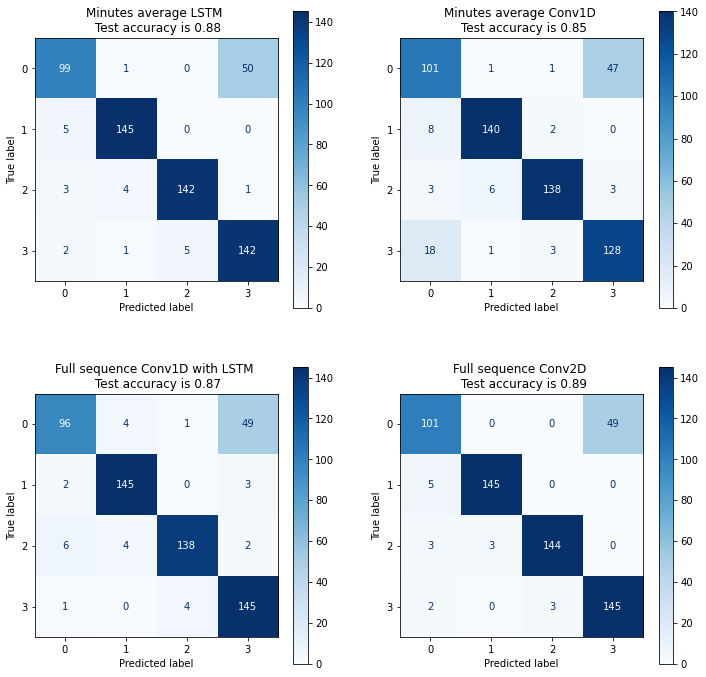

In [697]:
#Display 4 competing models
labels = ["0", "1", "2","3"]
fig = plt.figure(figsize=(12,12))

ax1=plt.subplot(2, 2, 1)
ax1.title.set_text('Minutes average LSTM \n Test accuracy is '+ acc1)
disp1.plot(cmap=plt.cm.Blues,ax=ax1)

ax2=plt.subplot(2, 2, 2)
ax2.title.set_text('Minutes average Conv1D \n Test accuracy is '+acc2)
disp2.plot(cmap=plt.cm.Blues,ax=ax2)

ax3=plt.subplot(2, 2, 3)
ax3.title.set_text('Full sequence Conv1D with LSTM \n Test accuracy is '+acc3)
disp3.plot(cmap=plt.cm.Blues,ax=ax3)

ax4=plt.subplot(2, 2, 4)
ax4.title.set_text('Full sequence Conv2D \n Test accuracy is '+acc4)
disp4.plot(cmap=plt.cm.Blues,ax=ax4)

plt.show()

* All 4 models produce very similar results that can be spotted on confusion matrix. They all are mostly vulnerable to predicting the operating mode when both angle and generator are healthy, classifyng 47-50 healthy turbines as damaged.

* Since the highest testing accuracy and the fastest speed of training belongs to Conv2D model, I would argue for choosing this network.

In [701]:
#save the model
#model_Conv2D.save('Sinkov_model.h5')